In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
import numpy as np
import re
import os
import glob

In [2]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import scipy.stats as stats
import random
from scipy.stats import ks_2samp

/sdd/bgi/miniconda3/envs/scanpy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import seaborn as snss

# import data

In [4]:
# file path
# h5ad file path
maca1_chip_list = glob.glob('../macaca#1_cellbins/cell_bin_cla_240220/*digitalized.h5ad')
maca2_chip_list = glob.glob('../macaca#1_cellbins/cellbin_allslice_v0410/*digitalized.h5ad')

In [6]:
# annofile path
maca1_anno = "../SpatialID_0218/macaque1_CLA_49c_csv/"
maca2_anno = "../SpatialID_0218/macaque4_CLA_49c_csv/"

In [7]:
## import macaque1 data
maca1_adata_list = []

for pth in maca1_chip_list:
    adata = ad.read_h5ad(pth)
    adata.uns['chipid'] = os.path.basename(pth).split("_digitalized")[0]
    cell_annot_pth = maca1_anno + "spatialID-"+ adata.uns['chipid'] +"_snRNA_CLA_SCT_20240111_res12_49_unfil_mq1.csv"
    cell_annot = pd.read_table(cell_annot_pth,sep= ',',index_col= 0,dtype={0: str})
    cell_annot.index = cell_annot.index.astype('str')
    adata.obs['cell.annot'] = cell_annot.reindex(adata.obs.index)["celltype_pred"].fillna("unassigned").tolist()
#     adata.obs.loc[adata.obs['nFeature_Spatial'] < 100, 'cell.annot'] = 'unassigned' ### !!!filter cells with nfeature less than 100
    
    ### ！combine oligo clusters
    adata.obs["cell.annot"] = adata.obs["cell.annot"].replace("Oligo_1", "Oligo_0")
    
    maca1_adata_list.append(adata)

maca1_dict = {adata.uns['chipid']: adata for adata in maca1_adata_list} 
    
# put in A-P order
order = ['T105', 'T103', 'T101', 'T99', 'T97', 'T95', 'T93', 'T91', 'T89', 'T87', 'T85', 'T83', 'T81', 'T79', 'T77', 'T75', 'T73', 'T71', 'T67', 'T65', 'T63', 'T61', 'T59', 'T57', 'T55', 'T53', 'T51', 'T49', 'T47', 'T45', 'T43', 'T41', 'T39', 'T37', 'T33', 'T31', 'T29', 'T27','T26', 'T25','T28', 'T30', 'T32','T34']
maca1_adata_list = [x for _, x in sorted(zip(list(maca1_dict.keys()), maca1_adata_list), key=lambda pair: order.index(pair[0]))]

In [8]:
## import macaque2 data
maca2_adata_list = []

for pth in maca2_chip_list:
    adata = ad.read_h5ad(pth)
    adata.uns['chipid'] = os.path.basename(pth).split("_digitalized")[0]
    cell_annot_pth = maca2_anno + "spatialID-"+ adata.uns['chipid'] +"_snRNA_CLA_SCT_20240111_res12_49_unfil_mq4.csv"
    cell_annot = pd.read_table(cell_annot_pth,sep= ',',index_col= 0,dtype={0: str})
    cell_annot.index = cell_annot.index.astype('str')
    adata.obs['cell.annot'] = cell_annot.reindex(adata.obs.index)["celltype_pred"].fillna("unassigned").tolist()
#     adata.obs.loc[adata.obs['nFeature_Spatial'] < 100, 'cell.annot'] = 'unassigned' ### !!!filter cells with nfeature less than 100
    
    ###！combine oligo clusters
    adata.obs["cell.annot"] = adata.obs["cell.annot"].replace("Oligo_1", "Oligo_0")
    
    maca2_adata_list.append(adata)
    
maca2_dict = {adata.uns['chipid']: adata for adata in maca2_adata_list} 
    
# put in A-P order 
order = ['T1031','T1032','T1030','T1029','T1027','T1021','T1020','T1018','T1016','T1014','T1012','T1011','T1013','T1015','T1017','T1019','T1022','T1023','T1024','T1025','T1026','T1028','T1033']
maca2_adata_list = [x for _, x in sorted(zip(list(maca2_dict.keys()), maca2_adata_list), key=lambda pair: order.index(pair[0]))]

In [9]:
## check cell types

celltypes = []
for adata in maca1_adata_list:
    adata.obs['cell.annot'] = adata.obs['cell.annot'].astype('category')
    celltypes.append(adata.obs['cell.annot'].cat.categories.tolist())

celltype = list(set([item for sublist in celltypes for item in sublist]))
celltype = np.sort(celltype)
len(celltype)

48

# un-uniform distrubution test for macaque1

In [10]:
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests
from statsmodels.stats import meta_analysis

In [11]:
# remove total cell number < 10 per slice
celltype_over = []
for cell in celltype:
    total_cell = 0
    for adata in maca1_adata_list:
        total_cell = total_cell + len(adata[adata.obs['cell.annot']== cell]) 
#     print(total_cell)
    if total_cell > 10 * len(maca1_adata_list):
        celltype_over.append(cell)
    else:
        print('remove', cell)


len(celltype_over)

remove GABA_DRD2_1
remove GABA_DRD2_2


46

In [12]:
## calculate p values for all celltypes in each slice|
from scipy import stats
n_celltypes = len(celltype_over)

p_values_x = np.full((n_celltypes, len(maca1_adata_list)), np.nan) # take middle 20 sections into calculation
p_values_y = np.full((n_celltypes, len(maca1_adata_list)), np.nan)

p_values_z = np.full(n_celltypes, np.nan)
corrs_z = np.full(n_celltypes, np.nan)
for i,cell in enumerate(celltype_over):
    cell_points_z = []
    points_z = []
    cell_num_z = []
    all_cell_num_z = []
    for j,adata in enumerate(maca1_adata_list): 
        current_cell = adata.obs['cell.annot'] == cell
        all_cell = adata.obs['cell.annot']!='unassigned'
#         # for z axis test
        cell_num_z.append(sum(current_cell))
        all_cell_num_z.append(sum(all_cell))

        # z test with coordinates
#         cell_points_z = np.concatenate((cell_points_z, adata[current_cell].obs['z(1mm)'].values))
#         points_z = np.concatenate((points_z, adata[all_cell].obs['z(1mm)'].values))  
        if sum(current_cell) > 0: 

            
            cell_points_x = adata[current_cell].obs['digital_layer'].values
            cell_points_y = adata[current_cell].obs['digital_column'].values
            points_x = adata[all_cell].obs['digital_layer'].values
            points_y = adata[all_cell].obs['digital_column'].values

            # Perform KS test for x and y axis
            _, p_value_x = ks_2samp(cell_points_x, points_x)
            _, p_value_y = ks_2samp(cell_points_y, points_y)
            
            p_values_x[i,j] = p_value_x
            p_values_y[i,j] = p_value_y
            
        
#     cell_num_z = (cell_num_z - np.min(cell_num_z)) / (np.max(cell_num_z) - np.min(cell_num_z))
#     all_cell_num_z = (all_cell_num_z - np.min(all_cell_num_z)) / (np.max(all_cell_num_z) - np.min(all_cell_num_z))
    
#     _, p_value_z = ks_2samp(cell_points_z, points_z)
#     corr_z, p_value_z = stats.pearsonr(cell_num_z, all_cell_num_z)


#     p_values_z[i] = p_value_z
#     corrs_z[i] = corr_z

In [13]:
# correct p for each slide

corrected_p_values_x = p_values_x
corrected_p_values_y = p_values_y

for i in range(20):
    corrected_p_values_x[:,i] = multipletests(p_values_x[:,i], method='bonferroni')[1]
    corrected_p_values_y[:,i] = multipletests(p_values_y[:,i], method='bonferroni')[1]
    
# corrected_p_values_z = multipletests(p_values_z, method='bonferroni')[1]

In [14]:
# intergrate p values for each cell type

from scipy.stats import combine_pvalues
integrated_p_values_x = np.full(n_celltypes, np.nan)
integrated_p_values_y = np.full(n_celltypes, np.nan)
# integrated_p_values_z = np.full(61, np.nan)
for i in range(n_celltypes):
    arr_x = corrected_p_values_x[i,:]
    arr_y = corrected_p_values_y[i,:]
    integrated_p_values_x[i] = combine_pvalues(arr_x[~np.isnan(arr_x)], method='fisher').pvalue
    integrated_p_values_y[i] = combine_pvalues(arr_y[~np.isnan(arr_y)], method='fisher').pvalue

In [15]:
maca1_p = np.column_stack((integrated_p_values_x, integrated_p_values_y))

maca1_celltypes = celltype_over

In [16]:
# build df for upset plot
upset_df = pd.DataFrame()
upset_df['ML non-uniform'] = integrated_p_values_x < 0.001
upset_df['DV non-uniform'] = integrated_p_values_y < 0.001
# upset_df['AP non-uniform'] = corrs_z<0.5 

upset_df['celltype'] = celltype_over

upset_df['SuperCluster'] = [item.rpartition('_')[0] for item in celltype_over]
upset_df['Group'] = [item.split('_', 1)[0] for item in celltype_over]
upset_df.loc[~upset_df['Group'].isin(['GLUT', 'GABA']), 'Group'] = 'NON'

upset_df = upset_df.set_index(['ML non-uniform','DV non-uniform'])

# upset_df.to_csv('maca1_distribution_state.csv')

In [17]:
maca1_dis_df = upset_df

# un-uniform distrubution test for macaque2

In [27]:
# remove total cell number < 10 per slice
celltype_over = []
for cell in celltype:
    total_cell = 0
    for adata in maca2_adata_list:
        total_cell = total_cell + len(adata[adata.obs['cell.annot']== cell]) 
#     print(total_cell)
    if total_cell > 10 * len(maca2_adata_list):
        celltype_over.append(cell)
    else:
        print('remove', cell)


len(celltype_over)


remove GABA_DRD2_1
remove GABA_DRD2_2


46

In [28]:
## calculate p values for all celltypes in each slice
from scipy import stats
n_celltypes = len(celltype_over)

p_values_x = np.full((n_celltypes, len(maca2_adata_list)), np.nan) # take middle 20 sections into calculation
p_values_y = np.full((n_celltypes, len(maca2_adata_list)), np.nan)

p_values_z = np.full(n_celltypes, np.nan)
corrs_z = np.full(n_celltypes, np.nan)
for i,cell in enumerate(celltype_over):
    cell_points_z = []
    points_z = []
    cell_num_z = []
    all_cell_num_z = []
    for j,adata in enumerate(maca2_adata_list): 
        current_cell = adata.obs['cell.annot'] == cell
        all_cell = adata.obs['cell.annot']!='unassigned'
#         # for z axis test
        cell_num_z.append(sum(current_cell))
        all_cell_num_z.append(sum(all_cell))

        # z test with coordinates
#         cell_points_z = np.concatenate((cell_points_z, adata[current_cell].obs['z(1mm)'].values))
#         points_z = np.concatenate((points_z, adata[all_cell].obs['z(1mm)'].values))  
        if sum(current_cell) > 0: 

            
            cell_points_x = adata[current_cell].obs['digital_layer'].values
            cell_points_y = adata[current_cell].obs['digital_column'].values
            points_x = adata[all_cell].obs['digital_layer'].values
            points_y = adata[all_cell].obs['digital_column'].values

            # Perform KS test for x and y axis
            _, p_value_x = ks_2samp(cell_points_x, points_x)
            _, p_value_y = ks_2samp(cell_points_y, points_y)
            
            p_values_x[i,j] = p_value_x
            p_values_y[i,j] = p_value_y
            
        
#     cell_num_z = (cell_num_z - np.min(cell_num_z)) / (np.max(cell_num_z) - np.min(cell_num_z))
#     all_cell_num_z = (all_cell_num_z - np.min(all_cell_num_z)) / (np.max(all_cell_num_z) - np.min(all_cell_num_z))
    
#     _, p_value_z = ks_2samp(cell_points_z, points_z)
#     corr_z, p_value_z = stats.pearsonr(cell_num_z, all_cell_num_z)


#     p_values_z[i] = p_value_z
#     corrs_z[i] = corr_z

In [29]:
# correct p for each slide

corrected_p_values_x = p_values_x
corrected_p_values_y = p_values_y

for i in range(20):
    corrected_p_values_x[:,i] = multipletests(p_values_x[:,i], method='bonferroni')[1]
    corrected_p_values_y[:,i] = multipletests(p_values_y[:,i], method='bonferroni')[1]
    
# corrected_p_values_z = multipletests(p_values_z, method='bonferroni')[1]

In [30]:
# intergrate p values for each cell type

from scipy.stats import combine_pvalues
integrated_p_values_x = np.full(n_celltypes, np.nan)
integrated_p_values_y = np.full(n_celltypes, np.nan)
# integrated_p_values_z = np.full(61, np.nan)
for i in range(n_celltypes):
    arr_x = corrected_p_values_x[i,:]
    arr_y = corrected_p_values_y[i,:]
    integrated_p_values_x[i] = combine_pvalues(arr_x[~np.isnan(arr_x)], method='fisher').pvalue
    integrated_p_values_y[i] = combine_pvalues(arr_y[~np.isnan(arr_y)], method='fisher').pvalue

In [31]:
maca2_p = np.column_stack((integrated_p_values_x, integrated_p_values_y))

maca2_celltypes = celltype_over

In [32]:
# build df for upset plot
upset_df = pd.DataFrame()
upset_df['ML non-uniform'] = integrated_p_values_x < 0.001 
upset_df['DV non-uniform'] = integrated_p_values_y < 0.001 
# upset_df['AP non-uniform'] = corrs_z<0.5 

upset_df['celltype'] = celltype_over

upset_df['SuperCluster'] = [item.rpartition('_')[0] for item in celltype_over]
upset_df['Group'] = [item.split('_', 1)[0] for item in celltype_over]
upset_df.loc[~upset_df['Group'].isin(['GLUT', 'GABA']), 'Group'] = 'NON'

upset_df = upset_df.set_index(['ML non-uniform','DV non-uniform'])
# upset_df.to_csv('maca2_distribution_state.csv')


# upset_df

celltype     SuperCluster Group
ML non-uniform DV non-uniform                                          
False          True                 Astrocytes_0       Astrocytes   NON
True           True                 Astrocytes_1       Astrocytes   NON
False          True                 Endotheial_0       Endotheial   NON
               False                  GABA_CHC_9         GABA_CHC  GABA
True           True                  GABA_DRD2_0        GABA_DRD2  GABA
False          False                GABA_LAMP5_4       GABA_LAMP5  GABA
               False           GABA_LAMP5_LHX6_0  GABA_LAMP5_LHX6  GABA
               True                 GABA_PVALB_1       GABA_PVALB  GABA
               False               GABA_PVALB_12       GABA_PVALB  GABA
               False               GABA_PVALB_14       GABA_PVALB  GABA
               False                GABA_PVALB_2       GABA_PVALB  GABA
               False                GABA_PVALB_8       GABA_PVALB  GABA
               False                GABA_RELN_10        GABA_RELN  GABA
               False                GABA_RELN_13        GABA_RELN  GABA
               False                 GABA_SST_15         GABA_SST  GABA
               False                  GABA_SST_5         GABA_SST  GABA
               False                  GABA_SST_7         GABA_SST  GABA
               False                 GABA_VIP_11         GABA_VIP  GABA
               False                  GABA_VIP_3         GABA_VIP  GABA
               False                  GABA_VIP_6         GABA_VIP  GABA
True           True                 GLUT_GNB4+_0       GLUT_GNB4+  GLUT
               True                 GLUT_GNB4+_1       GLUT_GNB4+  GLUT
               True                GLUT_GNB4+_11       GLUT_GNB4+  GLUT
               True                GLUT_GNB4+_13       GLUT_GNB4+  GLUT
False          False               GLUT_GNB4+_16       GLUT_GNB4+  GLUT
True           True                 GLUT_GNB4+_2       GLUT_GNB4+  GLUT
               True                 GLUT_GNB4+_3       GLUT_GNB4+  GLUT
False          True                 GLUT_GNB4+_4       GLUT_GNB4+  GLUT
               True                 GLUT_GNB4+_5       GLUT_GNB4+  GLUT
True           True                 GLUT_GNB4+_7       GLUT_GNB4+  GLUT
               True                 GLUT_GNB4+_8       GLUT_GNB4+  GLUT
False          True                GLUT_GNB4-_10       GLUT_GNB4-  GLUT
True           True                GLUT_GNB4-_14       GLUT_GNB4-  GLUT
False          False               GLUT_GNB4-_17       GLUT_GNB4-  GLUT
True           True                GLUT_GNB4-_18       GLUT_GNB4-  GLUT
               False               GLUT_GNB4-_20       GLUT_GNB4-  GLUT
False          True                GLUT_GNB4-_23       GLUT_GNB4-  GLUT
True           True                 GLUT_GNB4-_6       GLUT_GNB4-  GLUT
               True                 GLUT_GNB4-_9       GLUT_GNB4-  GLUT
False          True                 GLUT_VENO_12        GLUT_VENO  GLUT
True           True                 GLUT_VENO_15        GLUT_VENO  GLUT
False          True                 GLUT_VENO_21        GLUT_VENO  GLUT
               False                 Microglia_0        Microglia   NON
               False                       OPC_0              OPC   NON
               False                       OPC_1              OPC   NON
True           True                      Oligo_0            Oligo   NON

In [33]:
maca2_dis_df = upset_df
# maca2_dis_df

# define non-uniform cells with 2 macaques combined

In [45]:
maca1_dis_df.reset_index(inplace=True)
# maca1_dis_df

In [46]:
maca2_dis_df.reset_index(inplace=True)
# maca2_dis_df

In [47]:
dis_df = pd.merge(maca1_dis_df, maca2_dis_df, left_on='celltype', right_on='celltype')[['celltype','ML non-uniform_x','DV non-uniform_x','ML non-uniform_y','DV non-uniform_y','SuperCluster_x','Group_x']]

In [48]:
dis_df['ML non-uniform'] = dis_df['ML non-uniform_x'] & dis_df['ML non-uniform_y']
dis_df['DV non-uniform'] = dis_df['DV non-uniform_x'] & dis_df['DV non-uniform_y']

In [50]:
upset_df = dis_df.set_index(['ML non-uniform','DV non-uniform'])

In [73]:
upset_df

celltype  ML non-uniform_x  \
ML non-uniform DV non-uniform                                        
False          True                 Astrocytes_0              True   
True           True                 Astrocytes_1              True   
False          False                Endotheial_0             False   
               False                  GABA_CHC_9             False   
True           True                  GABA_DRD2_0              True   
False          False                GABA_LAMP5_4             False   
               False           GABA_LAMP5_LHX6_0             False   
               False                GABA_PVALB_1             False   
               False               GABA_PVALB_12             False   
               False               GABA_PVALB_14             False   
               False                GABA_PVALB_2             False   
               False                GABA_PVALB_8             False   
               False                GABA_RELN_10             False   
               False                GABA_RELN_13             False   
               False                 GABA_SST_15             False   
               False                  GABA_SST_5             False   
               False                  GABA_SST_7             False   
               False                 GABA_VIP_11             False   
               False                  GABA_VIP_3             False   
               False                  GABA_VIP_6             False   
True           True                 GLUT_GNB4+_0              True   
               True                 GLUT_GNB4+_1              True   
               True                GLUT_GNB4+_11              True   
               True                GLUT_GNB4+_13              True   
False          False               GLUT_GNB4+_16             False   
True           True                 GLUT_GNB4+_2              True   
False          True                 GLUT_GNB4+_3             False   
               True                 GLUT_GNB4+_4              True   
               True                 GLUT_GNB4+_5              True   
True           True                 GLUT_GNB4+_7              True   
               True                 GLUT_GNB4+_8              True   
False          True                GLUT_GNB4-_10             False   
True           True                GLUT_GNB4-_14              True   
False          False               GLUT_GNB4-_17             False   
True           True                GLUT_GNB4-_18              True   
               False               GLUT_GNB4-_20              True   
False          True                GLUT_GNB4-_23             False   
True           True                 GLUT_GNB4-_6              True   
               True                 GLUT_GNB4-_9              True   
False          False                GLUT_VENO_12             False   
               True                 GLUT_VENO_15             False   
               True                 GLUT_VENO_21             False   
               False                 Microglia_0              True   
               False                       OPC_0             False   
               False                       OPC_1              True   
True           True                      Oligo_0              True   

                               DV non-uniform_x  ML non-uniform_y  \
ML non-uniform DV non-uniform                                       
False          True                        True             False   
True           True                        True              True   
False          False                      False             False   
               False                      False             False   
True           True                        True              True   
False          False                      False             False   
               False                      False             False   
               False                      False           

(0.0, 20.0)

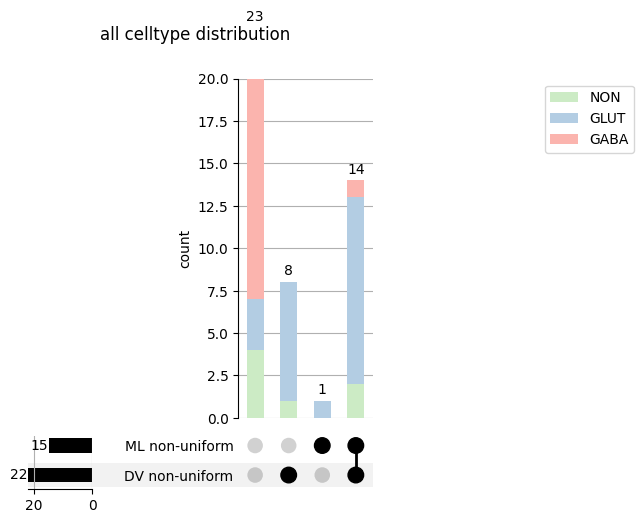

In [51]:
## all cells

upset = UpSet(upset_df, show_counts=True, #orientation="vertical",
              intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(by="Group_x", colors=cm.Pastel1,
                       title="count", elements=10)
upset.plot()
plt.legend(loc='upper right', bbox_to_anchor=(3, 1))
plt.suptitle("all celltype distribution")
plt.ylim([0,20])
# plt.savefig("m2_cell_distribution.pdf", format='pdf')

(0.0, 20.0)

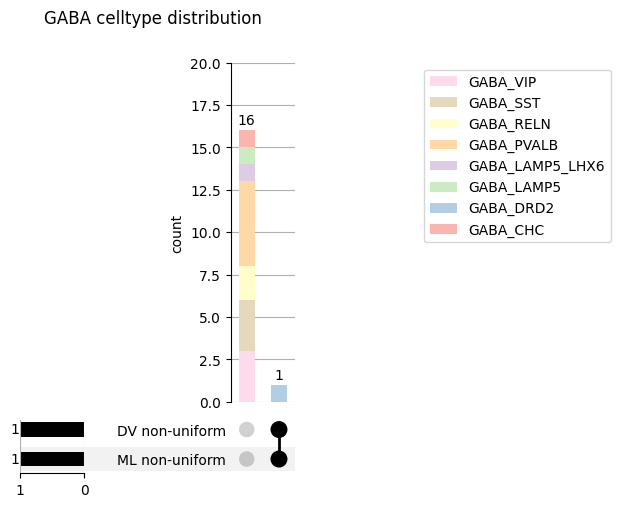

In [52]:
## GABA
upset_gaba = upset_df[upset_df.Group_x == "GABA"]
upset = UpSet(upset_gaba,show_counts=True, #orientation="vertical",
              intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(by="SuperCluster_x", colors=cm.Pastel1,
                       title="count", elements=10)
upset.plot()
plt.legend(loc='upper right', bbox_to_anchor=(6, 1))
plt.suptitle("GABA celltype distribution")

plt.ylim([0,20])
# plt.savefig("m2_upset_gaba.pdf", format="pdf")

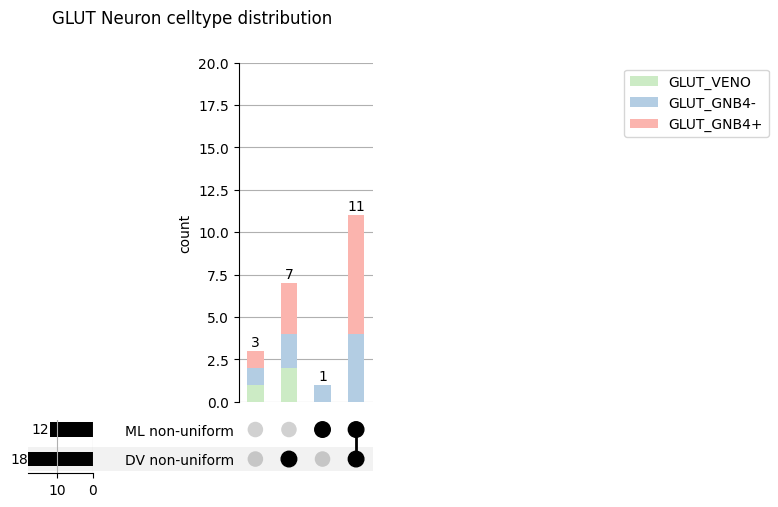

In [53]:
## GLUT

upset_ex = upset_df[upset_df.Group_x == "GLUT"]

upset = UpSet(upset_ex,show_counts=True, #orientation="vertical",
              intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(by="SuperCluster_x", colors=cm.Pastel1,
                       title="count", elements=10)
upset.plot()
plt.ylim([0,20])
plt.legend(loc='upper right', bbox_to_anchor=(4, 1))
plt.suptitle("GLUT Neuron celltype distribution ")

plt.savefig("m2_upset_glut.pdf", format="pdf")

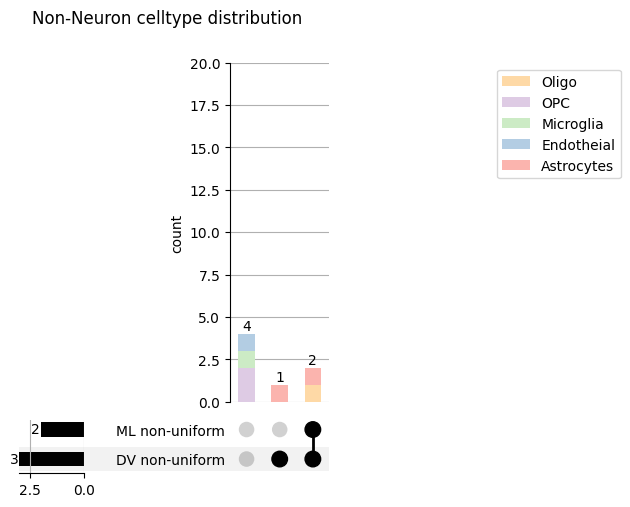

In [54]:
## Non neuron

upset_non = upset_df[upset_df.Group_x == "NON"]
upset = UpSet(upset_non,show_counts=True, #orientation="vertical",
              intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(by="SuperCluster_x", colors=cm.Pastel1,
                       title="count", elements=10)
upset.plot()
plt.legend(loc='upper right', bbox_to_anchor=(4, 1))
plt.suptitle("Non-Neuron celltype distribution ")

plt.ylim([0,20])
plt.savefig("m2_upset_non.pdf", format="pdf")